# Physics example 1: classification of SUSY signal over SM background events

In the first example we look at building a multi-layered dense neural network with tensorflow to classify SUSY signal events over background events.

Further down, in 'Physics example 2', we look at the example of a simple regression test. 

In [1]:
#import all the required libraries here
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import model_selection,preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### First load the dataset and define the variables to train over

We will use the popular python analysis library pandas to load and manipulate the data within a dataframe.

The dataset we will use has 50K events, 25K of each signal and background. This is indicated by the column 'signal' (0 for background, 1 for signal). Several high and low level physics variables have been precalculated and stored, we will use a typical subset used in SUSY analyses as features for the network to train on.

The background consists of ttbar events and the signal consists of the T2tt simplified SUSY model, where stops are pair produced and decay to a weakly interacting LSP and a top quark. For this particular point the mass of the stop is 900 GeV and the mass of the LSP is 100 GeV

In [2]:
dfFull = pd.read_pickle('data/stop50K.pkl')

#Pick a subset of features from the dataframe
subset=['signal', #1 for signal and 0 for background
        'HT','MET', #energy sums
        'MT','MT2W', #topological variables
        'n_jet','n_bjet', #jet and b-tag multiplicities
        'sel_lep_pt0','sel_lep_eta0','sel_lep_phi0', #lepton 4-vector
        'selJet_phi0','selJet_pt0','selJet_eta0','selJet_m0',# lead jet 4-vector
        'selJet_phi1','selJet_pt1','selJet_eta1','selJet_m1',# second jet 4-vector
        'selJet_phi2','selJet_pt2','selJet_eta2','selJet_m2']# third jet 4-vector

df = dfFull[subset]

print 'The df has',(df.signal==1).sum(),'signal events and',(df.signal==0).sum(),'background events'
print '\nSummary statistics:'
df.describe()

The df has 25000 signal events and 25000 background events

Summary statistics:


,signal,HT,MET,MT,MT2W,n_jet,n_bjet,sel_lep_pt0,sel_lep_eta0,sel_lep_phi0,...,selJet_eta0,selJet_m0,selJet_phi1,selJet_pt1,selJet_eta1,selJet_m1,selJet_phi2,selJet_pt2,selJet_eta2,selJet_m2
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.500000,742.551463,363.747724,221.277141,268.054783,4.724580,1.583620,114.237015,-0.007056,0.014250,...,-0.004812,44.471903,-0.008357,176.821585,-0.001976,21.578669,-0.005161,112.386898,0.000876,14.327973
std,0.500005,321.861028,176.450302,224.857741,208.685966,0.945781,0.658344,92.876602,0.958646,1.815952,...,0.988404,35.418186,1.814681,95.904711,1.051974,16.730063,1.817073,54.982978,1.103517,8.909093
min,0.000000,300.200581,200.001801,0.010894,87.197792,4.000000,1.000000,30.000671,-2.399237,-3.141541,...,-2.399026,-0.000008,-3.141565,60.003651,-2.399254,-0.000007,-3.141554,40.403805,-2.399924,-0.000009
25%,0.000000,515.653478,231.447735,55.850130,144.599158,4.000000,1.000000,51.892692,-0.694333,-1.563840,...,-0.706146,19.488720,-1.580130,113.804325,-0.761758,11.617799,-1.574401,74.839840,-0.809226,8.714634
50%,0.500000,669.581915,294.372787,118.540216,185.339196,4.000000,1.000000,83.868206,-0.007627,0.015605,...,-0.011920,32.103722,-0.020845,152.322464,-0.001517,16.859715,-0.003988,98.857002,-0.003683,12.174201
75%,1.000000,882.477468,448.979073,341.823580,302.698029,5.000000,2.000000,143.000420,0.674517,1.588874,...,0.699493,59.373569,1.566254,210.309380,0.757596,25.511512,1.564207,134.401848,0.814591,17.407667
max,1.000000,4080.908722,2257.441162,2155.218835,999.000000,13.000000,6.000000,1199.193604,2.399437,3.141548,...,2.400000,371.054840,3.141547,1328.631958,2.399520,252.995590,3.141570,816.794495,2.399620,170.561081


### Preparing the data for a neural network training: splitting and standardising

To prepare the data for machine learning with a neural network we need to split into a testing and training set, to avoid bias when evaluating the performance. We additionally adopt the naming convention of 'y' for target variables and 'X' for input variables.

It is also sensible to 'standardise' the input variables for a neural network by scaling them to have a standard deviation between -1 and 1 and a mean of 0. This means all the features have the same effective weight when training the network. 

For these task we use functions from the useful python ML library 'scikit-learn'.

In [3]:
X=df.drop('signal',axis=1)
y=df['signal']#.values.reshape(len(df),1)

#Split with 30% of data kept aside for testing
X_train,X_test,y_train,y_test = model_selection.train_test_split(X, y, test_size=0.3, 
                                                                 random_state=42)
print len(X_train), X_train.shape, X_train.size
print len(X_test), X_test.shape, X_test.size

#Now do the standardisation on the train set
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns,index=X_train.index)

#Additionally apply the scaling it to the test set
X_test = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns,index=X_test.index)

#Now check it worked
print 'Standardised statistics:'
X_train.describe()

35000 (35000, 21) 735000
15000 (15000, 21) 315000
Standardised statistics:


,HT,MET,MT,MT2W,n_jet,n_bjet,sel_lep_pt0,sel_lep_eta0,sel_lep_phi0,selJet_phi0,...,selJet_eta0,selJet_m0,selJet_phi1,selJet_pt1,selJet_eta1,selJet_m1,selJet_phi2,selJet_pt2,selJet_eta2,selJet_m2
count,3.500000e+04,3.500000e+04,3.500000e+04,3.500000e+04,3.500000e+04,3.500000e+04,3.500000e+04,3.500000e+04,3.500000e+04,3.500000e+04,...,3.500000e+04,3.500000e+04,3.500000e+04,3.500000e+04,3.500000e+04,3.500000e+04,3.500000e+04,3.500000e+04,3.500000e+04,3.500000e+04
mean,-3.248195e-18,1.632218e-16,5.730020e-17,-2.472689e-16,1.801733e-17,8.232145e-17,-5.278317e-18,-3.654220e-18,-2.598556e-17,-2.030122e-17,...,2.456448e-17,4.425666e-17,-2.030122e-18,5.288468e-17,-7.359193e-18,1.478436e-16,-7.206933e-18,5.633589e-17,-3.035033e-17,-3.375078e-17
std,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,...,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00
min,-1.368469e+00,-9.262559e-01,-9.847476e-01,-8.655500e-01,-7.645763e-01,-8.855276e-01,-9.077779e-01,-2.487855e+00,-1.737212e+00,-1.739139e+00,...,-2.420621e+00,-1.253964e+00,-1.728099e+00,-1.216301e+00,-2.274770e+00,-1.293265e+00,-1.720359e+00,-1.305931e+00,-2.168273e+00,-1.607664e+00
25%,-7.071454e-01,-7.486442e-01,-7.346447e-01,-5.920110e-01,-7.645763e-01,-8.855276e-01,-6.731851e-01,-7.206661e-01,-8.695241e-01,-8.651510e-01,...,-7.078108e-01,-7.067683e-01,-8.633657e-01,-6.560735e-01,-7.184153e-01,-5.989303e-01,-8.657673e-01,-6.833018e-01,-7.326671e-01,-6.294022e-01
50%,-2.224708e-01,-3.953839e-01,-4.525130e-01,-3.960517e-01,-7.645763e-01,-8.855276e-01,-3.290017e-01,-4.217524e-03,-5.421630e-03,6.686673e-03,...,-1.790476e-03,-3.475428e-01,-7.470431e-03,-2.534409e-01,2.264507e-03,-2.832425e-01,-2.520143e-03,-2.488276e-01,-3.503339e-03,-2.453293e-01
75%,4.343679e-01,4.828694e-01,5.361021e-01,1.652261e-01,2.910101e-01,6.334621e-01,3.115738e-01,7.140622e-01,8.635957e-01,8.691091e-01,...,7.114783e-01,4.223671e-01,8.676704e-01,3.512012e-01,7.239228e-01,2.400922e-01,8.621717e-01,4.023330e-01,7.365034e-01,3.462817e-01
max,1.031759e+01,1.069705e+01,7.912997e+00,3.498349e+00,8.735701e+00,6.709421e+00,1.125762e+01,2.500763e+00,1.726884e+00,1.732405e+00,...,2.424555e+00,9.196530e+00,1.739100e+00,1.196143e+01,2.274782e+00,1.274889e+01,1.732523e+00,1.277625e+01,2.170020e+00,1.752434e+01


### Building the neural network model

Now we have a prepared dataset ready for our neural network we need to build the model with tensorflow. Working from the example from 'gaussian.ipynb', build a 2 hidden layer network with 50 nodes on each layer. Therefore requiring 3 sets of weight and biases. We will choose the activation function of the internal nodes to be a RELU.

The input size will be the number of features available in X and the output will be one node with a sigmoid function to choose between 1 or 0 (signal or background).

In [4]:
def model(x, input_size=21, layer_size=50, sigmoid_out=True, scope_name='model'):
    #This ensuring the variables are defined within the scope of the model
    with tf.variable_scope(scope_name) as scope:
        w1 = tf.get_variable('w1', shape=(input_size, layer_size), dtype=tf.float64,
                initializer=tf.random_normal_initializer(stddev=0.1))
        b1 = tf.get_variable('b1', shape=(layer_size), dtype=tf.float64,
                initializer=tf.constant_initializer(0.1))
        w2 = tf.get_variable('w2', shape=(layer_size, layer_size), dtype=tf.float64,
                initializer=tf.random_normal_initializer(stddev=0.1))
        b2 = tf.get_variable('b2', shape=(layer_size), dtype=tf.float64,
                initializer=tf.constant_initializer(0.1))
        w3 = tf.get_variable('w3', shape=(layer_size, 1), dtype=tf.float64,
                initializer=tf.random_normal_initializer(stddev=0.1))
        b3 = tf.get_variable('b3', shape=(1), dtype=tf.float64,
                initializer=tf.constant_initializer(0.1))
    
    l1 = tf.nn.relu(tf.add(b1, tf.matmul(x, w1)))
    l2 = tf.nn.relu(tf.add(b2, tf.matmul(l1, w2)))
    logits = tf.add(b3, tf.matmul(l2, w3))
    return logits, tf.sigmoid(logits)
    

#Define the placeholder for the input

###### YOUR CODE HERE ######
x = tf.placeholder(tf.float64, shape=[None, 21])
logits, f = model(x)

In [5]:
print x

Tensor("Placeholder:0", shape=(?, 21), dtype=float64)


### Add the training operations

As in the gaussian example we want to define the outputs to train to and use the binary cross entropy loss function.

In [6]:
# output
labels = tf.placeholder(tf.float64, shape=[None, 1])
loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits))
minimize_loss = tf.train.AdamOptimizer().minimize(loss)

### Run the training

Compile the model into a session and run the training as it has been setup, as in the gaussian example.

However, in this case we are going to train over mini-batches of 1024 events each step.

In [8]:
#Set up and initialise the session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

loss_train = []
loss_test = []
###### YOUR CODE HERE ######

nEpochs=10
batch_size=1024

#Loop over epochs but this 
# I'll leave the code in place for you
# Note that we do an inner loop on each epoch selecting a batch of events
# We also have to make sure to format the pandas input properly with np.vstack
for i in range(nEpochs):
    loss_batch=[]
    for start,end in zip(range(0,len(X_train),batch_size),
                         range(batch_size,len(X_train)+1,batch_size)):
        loss_,_ = sess.run([loss,minimize_loss],
                          #feed_dict={x: X_train[start:end], labels: y_train[start:end]})
                           feed_dict={x: np.vstack(X_train.as_matrix())[start:end], labels: np.vstack(y_train)[start:end]})
        loss_batch.append(loss_)
        #print loss_
    #print loss_batch
    loss_ = np.mean(loss_batch)
    loss_train.append(loss_)
    print 'Epoch',i,';',
    print 'Train loss',loss_,';',
    loss_ = sess.run(loss, feed_dict={x: np.vstack(X_test.as_matrix()), labels: np.vstack(y_test)})
    loss_test.append(loss_)
    print 'Test loss',loss_

 Epoch 0 ; Train loss 0.6075938136311796 ; Test loss 0.4977143599601532
Epoch 1 ; Train loss 0.39789917936303815 ; Test loss 0.3169267855636043
Epoch 2 ; Train loss 0.2811587581058208 ; Test loss 0.2651844127287096
Epoch 3 ; Train loss 0.2539935716510409 ; Test loss 0.25645562857023957
Epoch 4 ; Train loss 0.24715325851186887 ; Test loss 0.2525474265058702
Epoch 5 ; Train loss 0.243222810252955 ; Test loss 0.24978099280649985
Epoch 6 ; Train loss 0.2402710039788398 ; Test loss 0.24774898472666404
Epoch 7 ; Train loss 0.23794101769404694 ; Test loss 0.24614214652899305
Epoch 8 ; Train loss 0.2360360744166435 ; Test loss 0.24483794387850435
Epoch 9 ; Train loss 0.23442615169044115 ; Test loss 0.24372268102128503


In [10]:
print zip(range(0,len(X_train),batch_size),
                    range(batch_size,len(X_train)+1,batch_size))

[(0, 1024), (1024, 2048), (2048, 3072), (3072, 4096), (4096, 5120), (5120, 6144), (6144, 7168), (7168, 8192), (8192, 9216), (9216, 10240), (10240, 11264), (11264, 12288), (12288, 13312), (13312, 14336), (14336, 15360), (15360, 16384), (16384, 17408), (17408, 18432), (18432, 19456), (19456, 20480), (20480, 21504), (21504, 22528), (22528, 23552), (23552, 24576), (24576, 25600), (25600, 26624), (26624, 27648), (27648, 28672), (28672, 29696), (29696, 30720), (30720, 31744), (31744, 32768), (32768, 33792), (33792, 34816)]


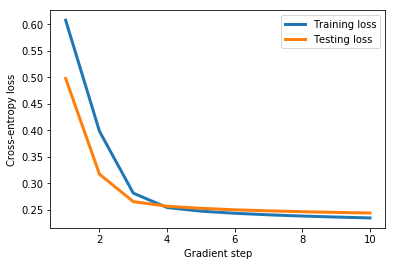

In [11]:
plt.plot(range(1, len(loss_train)+1), loss_train, lw=3, label="Training loss")
plt.plot(range(1, len(loss_train)+1), loss_test, lw=3, label="Testing loss")
plt.legend()
plt.xlabel("Gradient step"), plt.ylabel("Cross-entropy loss");

### Now check the performance

Check for over training by plotting the decision functions for test and train.

Check classification performance by plotting a ROC curve.

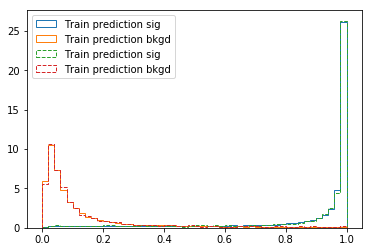

In [12]:
pred_train_sig = sess.run(f, feed_dict={x: X_train[y_train==1]})
pred_train_bkgd = sess.run(f, feed_dict={x: X_train[y_train==0]})
pred_test_sig = sess.run(f, feed_dict={x: X_test[y_test==1]})
pred_test_bkgd = sess.run(f, feed_dict={x: X_test[y_test==0]})


plt.hist(pred_train_sig,bins=50,range=(0.,1.),label='Train prediction sig',density=True,histtype='step')
plt.hist(pred_train_bkgd,bins=50,range=(0.,1.),label='Train prediction bkgd',density=True,histtype='step')
plt.hist(pred_test_sig,bins=50,range=(0.,1.),label='Train prediction sig',density=True,histtype='step',linestyle='dashed')
plt.hist(pred_test_bkgd,bins=50,range=(0.,1.),label='Train prediction bkgd',density=True,histtype='step',linestyle='dashed')


#plt.hist(pred_test,bins=50,range=(0,1),label='Test prediction',density=True,histtype='step')
plt.legend(loc='upper left')
plt.show()

If everything looks good, move on to the ROC curve

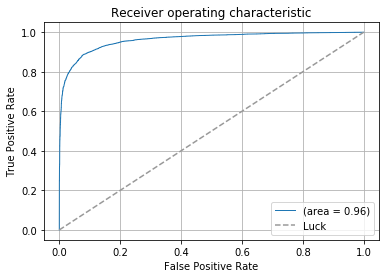

In [13]:
fpr, tpr, thresholds = roc_curve(y_test, sess.run(f, feed_dict={x:X_test}))
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw=1, label='(area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()   

# Physics example 2: regression to calculate MT

Further down, in 'Physics example 2', we look at the example of a simple regression test. 

Try to teach the network to learn M_T, the transverse mass of the lepton and MET. We will just do this with the signal dataset.

Again start with defining a subset of required variables and splitting.

In [ ]:
subset=[
        'MT',
        'MET','METPhi',
        'sel_lep_pt0','sel_lep_eta0','sel_lep_phi0' #lepton 4-vector
        ]

dfR = dfFull[(dfFull.signal==1)][subset]

XR=dfR.drop('MT',axis=1)
yR=dfR['MT']#.values.reshape(len(df),1)

#Split with 30% of data kept aside for testing
XR_train,XR_test,yR_train,yR_test = model_selection.train_test_split(XR, yR, test_size=0.3, 
                                                                 random_state=42)

### Building the neural network model

Build a two layer model as above, but this time the output layer should remain linear instead of sigmoid and we reduce the number of nodes per layer. You can modify the 'model' function or rewrite the function.

In [ ]:
###### YOUR CODE HERE ######
# xR = ...
# logitsR,fR = model(....)

### Define and run the training

This time we use mean squared error as a loss function

In [ ]:
###### YOUR CODE HERE ######
#labelsR = tf.placeholder(...)

lossR= tf.reduce_mean(tf.losses.mean_squared_error(labels=labelsR,predictions=fR))
#minimize_lossR = ...

In [ ]:
###### YOUR CODE HERE ######
# Define and initialise sessio

# Run, looping over epochs and batch as in the 6th cell above

In [ ]:
plt.plot(range(1, len(lossR_train)+1), lossR_train, lw=3, label="Training loss")
plt.plot(range(1, len(lossR_train)+1), lossR_test, lw=3, label="Testing loss")
plt.legend()
plt.xlabel("Gradient step"), plt.ylabel("Mean squared error loss");

### Now make some output

This time just plot the predicted vs the true M_T for the training set

In [ ]:
predR_test = sessR.run(fR, feed_dict={xR: XR_test})

plt.hist(predR_test,bins=100,range=(0,1000),label='Prediction',alpha=0.7)
plt.hist(yR_test,bins=100,range=(0,1000),label='Truth',alpha=0.7)
plt.legend()
plt.show()

How does it look? Can you tweak the model to improve performance?